El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_762500/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = "2023-07-29" # Not used

# Load data

In [3]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 13 columns):
 #   Column          

In [4]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0xe7af1c70f8f089c4c3bd71999692c6c5a15d9e2a,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 12:28:01,1
1,0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 02:16:23,1
2,0xd82d005e8f8d5385db40ba23884a5c967bb1e8af,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 00:38:22,1
3,0xf4c64db66ffb301985f5ecd85c8f3f9c02f2659d,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:47:08,1
4,0xd5e9ef1cedad0d135d543d286a2c190b16cbb89e,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:32:15,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                         1942
mean     8 days 02:39:25.396498455
std      3 days 01:18:26.795947483
min                5 days 00:00:00
25%                7 days 00:00:00
50%                7 days 00:00:00
75%                7 days 00:00:00
max               14 days 00:00:00
dtype: object

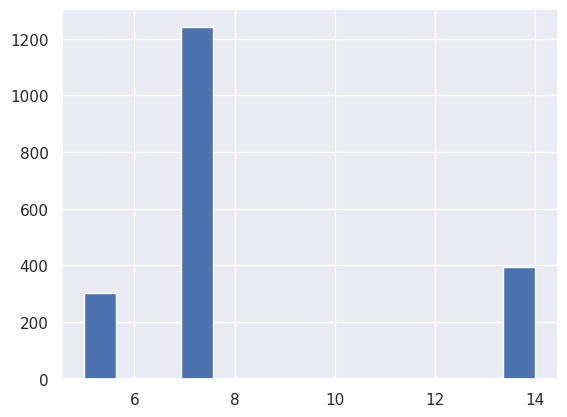

In [5]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [6]:
delta.value_counts()

7 days     1242
14 days     393
5 days      303
10 days       4
dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

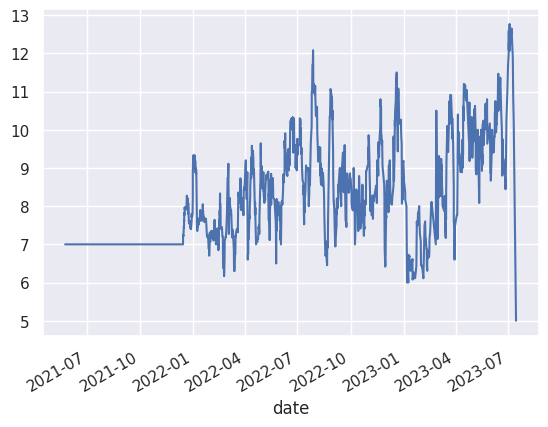

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Monday       346
Tuesday      326
Wednesday    324
Thursday     305
Friday       257
Saturday     199
Sunday       185
Name: start, dtype: int64

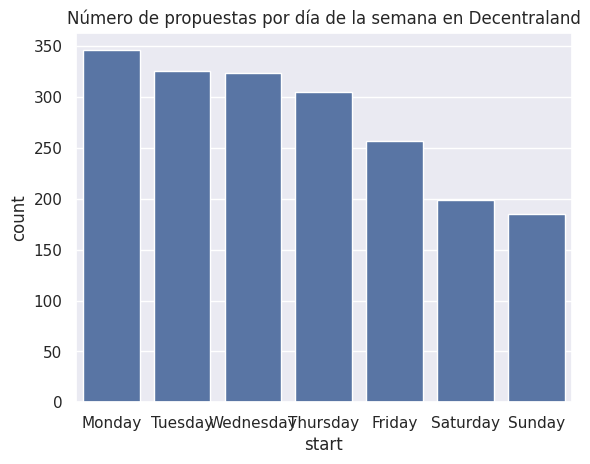

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

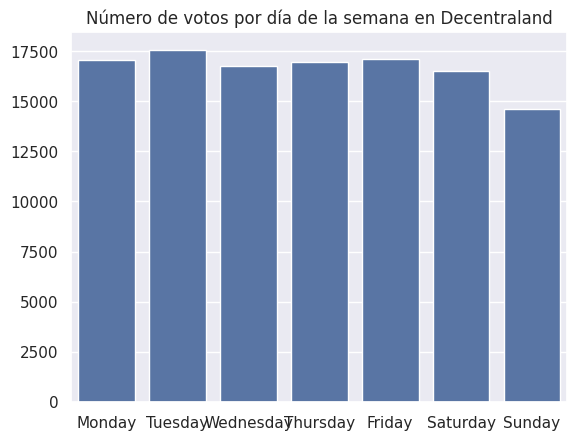

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

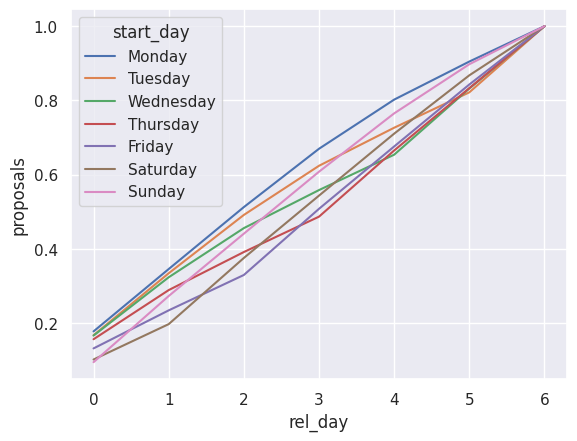

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

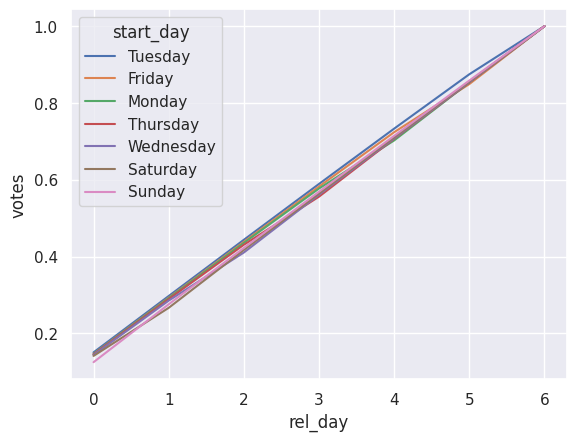

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

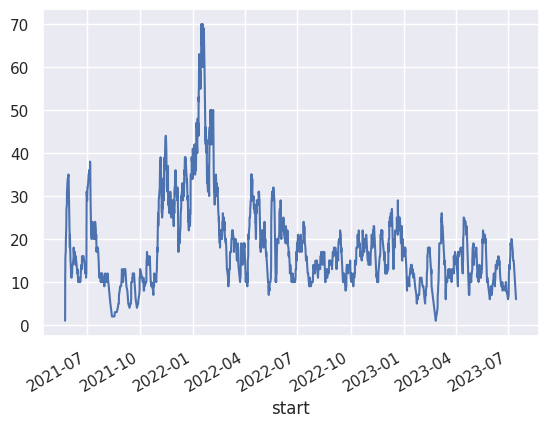

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                            W-SUN        W-MON        W-TUE  \
votes in open proposals (train) count   112.000000   113.000000   113.000000   
                                mean    970.964286   976.212389   962.327434   
                                std     797.179374   785.312852   790.255920   
                                min       9.000000     0.000000    19.000000   
                                50%     766.000000   780.000000   782.000000   
                                max    4449.000000  4137.000000  3816.000000   
users in open proposals (train) count   112.000000   113.000000   113.000000   
                                mean    298.178571   301.026549   298.867257   
                                std     149.621999   152.687967   146.409559   
                                min       8.000000     0.000000    17.000000   
                                50%     302.000000   300.000000   295.000000   
                                max     755.000000   735.000000   638.000000   
open proposals                  count   112.000000   113.000000   113.000000   
                                mean     20.026786    19.628319    19.752212   
                                std      10.732169    11.037432    10.831939   
                                min       2.000000     0.000000     2.000000   
                                50%      18.000000    17.000000    17.000000   
                                max      70.000000    70.000000    64.000000   
votes in test                   count   112.000000   113.000000   113.000000   
                                mean    297.991071   262.796460   273.681416   
                                std     243.088331   206.598219   208.656727   
                                min      13.000000     0.000000     4.000000   
                                50%     230.000000   212.000000   224.000000   
                                max    1290.000000   818.000000   956.000000   
users in test                   count   112.000000   113.000000   113.000000   
                                mean    115.910714   108.274336   114.008850   
                                std      73.143639    69.113164    70.198761   
                                min      12.000000     0.000000     4.000000   
                                50%     104.000000   102.000000   120.000000   
                                max     346.000000   312.000000   351.000000   
vpp test                        count   112.000000   112.000000   113.000000   
                                mean     17.365290    15.710916    16.773838   
                                std      16.040241    14.569736    16.222471   
                                min       1.529412     1.772727     1.533333   
                                50%      12.041667    11.348718    10.954545   
                                max      75.363636    81.800000    95.750000   
vpu test                        count   112.000000   112.000000   113.000000   
                                mean      2.403843     2.281722     2.266093   
                                std       0.839444     0.745821     0.706652   
                                min       1.000000     1.125000     1.000000   
                                50%       2.207692     2.119840     2.131579   
                                max       5.000000     5.473214     3.934156   

f                                            W-WED        W-THU        W-SAT  
votes in open proposals (train) count   113.000000   112.000000   112.000000  
                                mean    933.026549   912.812500   937.875000  
                                std     751.395921   694.462700   743.515646  
                                min      21.000000    22.000000     5.000000  
                                50%     727.000000   750.500000   731.500000  
                                max    3752.000000  3322.000000  3699.000000  
users 

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_762500/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),108748.000000,110312.000000,108743.000000,105432.000000,102235.000000,105042.000000
users in open proposals (train),33396.000000,34016.000000,33772.000000,33227.000000,33152.000000,32854.000000
open proposals,2243.000000,2218.000000,2232.000000,2238.000000,2229.000000,2261.000000
votes in test,33375.000000,29696.000000,30926.000000,34106.000000,35465.000000,36445.000000
users in test,12982.000000,12235.000000,12883.000000,13416.000000,13463.000000,13751.000000
vpp test,1944.912451,1759.622544,1895.443702,2095.518029,2142.455485,2081.029603
vpu test,269.230412,255.552877,256.068506,265.213016,271.671226,276.511072


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-08-04 00:57:07)  =====
Currently open proposals: 9
Train votes in open proposals: 142
Test votes in open proposals:   48

===== Training on fold 1 (t: 2021-10-14 16:08:30)  =====
Currently open proposals: 14
Train votes in open proposals: 158
Test votes in open proposals:  132

===== Training on fold 2 (t: 2021-12-25 02:40:07)  =====
Currently open proposals: 29
Train votes in open proposals: 756
Test votes in open proposals:   99

===== Training on fold 3 (t: 2022-03-06 19:14:35)  =====
Currently open proposals: 18
Train votes in open proposals: 489
Test votes in open proposals:  157

===== Training on fold 4 (t: 2022-05-17 08:44:54)  =====
Currently open proposals: 33
Train votes in open proposals: 578
Test votes in open proposals:  283

===== Training on fold 5 (t: 2022-07-27 20:58:07)  =====
Currently open proposals: 11
Train votes in open proposals: 399
Test votes in open proposals:  219

===== Training on fold 6 (t: 2022-10-07 11:03:04)  =====
Cu

In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.145534,0.295240,0.233348,0.376813,0.136090,0.397702,0.291391,0.675023,0.113341,0.438782,0.311082,0.799737,0.376084,0.211757
std,0.074635,0.202277,0.186149,0.274633,0.046153,0.166852,0.168740,0.266477,0.038696,0.155283,0.165207,0.218007,0.092464,0.063021
min,0.013223,0.034551,0.030224,0.038666,0.057447,0.173956,0.089620,0.305715,0.059574,0.248250,0.119625,0.501199,0.214876,0.109091
25%,0.092749,0.174898,0.097619,0.271048,0.104942,0.313136,0.154362,0.450278,0.089351,0.329195,0.176279,0.601699,0.345361,0.183017
50%,0.153866,0.275910,0.200108,0.324772,0.148637,0.383927,0.297211,0.640202,0.113628,0.425972,0.313113,0.850245,0.369055,0.209502
75%,0.194445,0.340966,0.311088,0.372638,0.172856,0.443969,0.334095,0.920908,0.128134,0.518333,0.373684,1.000000,0.448175,0.254412
max,0.268333,0.747259,0.659491,1.000000,0.190909,0.747259,0.659491,1.000000,0.190909,0.747259,0.659491,1.000000,0.497674,0.308721


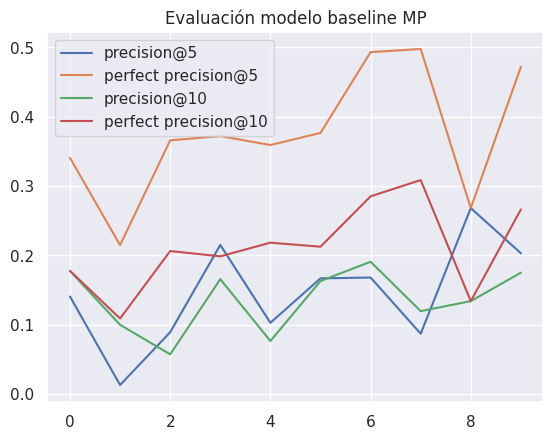

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,0.376084,1.0,0.970333,0.970333,0.211757,1.0,0.995063,0.995063,0.144764,1.0,0.998419,0.998419
std,0.092464,0.0,0.024256,0.024256,0.063021,0.0,0.008644,0.008644,0.044922,0.0,0.004339,0.004339
min,0.214876,1.0,0.923537,0.923537,0.109091,1.0,0.973738,0.973738,0.072727,1.0,0.986203,0.986203
25%,0.345361,1.0,0.956418,0.956418,0.183017,1.0,0.995568,0.995568,0.122011,1.0,1.000000,1.000000
50%,0.369055,1.0,0.971791,0.971791,0.209502,1.0,0.999483,0.999483,0.141087,1.0,1.000000,1.000000
75%,0.448175,1.0,0.988547,0.988547,0.254412,1.0,1.000000,1.000000,0.177015,1.0,1.000000,1.000000
max,0.497674,1.0,1.000000,1.000000,0.308721,1.0,1.000000,1.000000,0.217054,1.0,1.000000,1.000000


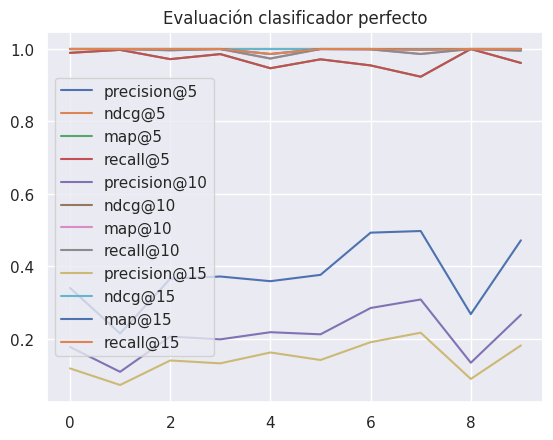

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    # open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    # train_filtered = train[train['itemID'].isin(open_proposals) ]
    # test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/112 [00:00<?, ?it/s]

In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2021-05-24 15:29:29 2023-07-20 15:42:01
t0: 2021-05-27 00:00:00
t1: 2021-06-03 00:00:00
t-2: 2023-07-13 00:00:00
t-1: 2023-07-20 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 112,
 'precision@5': 112,
 'ndcg@5': 112,
 'map@5': 112,
 'recall@5': 112,
 'precision@10': 112,
 'ndcg@10': 112,
 'map@10': 112,
 'recall@10': 112,
 'precision@15': 112,
 'ndcg@15': 112,
 'map@15': 112,
 'recall@15': 112}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2021-05-24 15:29:03')

Timestamp('2021-05-24 15:29:29')

,userID,itemID,timestamp,rating
10527,0x30b1f4bd5476906f38385b891f2c09973196b742,312c5654-0806-5473-8243-dbd6311208ed,2021-05-24 15:29:29,1
31518,0x30b1f4bd5476906f38385b891f2c09973196b742,f6bd4c7d-0d1e-5437-9cf9-e5e883522d3f,2021-05-24 15:30:54,1
69100,0xd689478d44a438798ee0dc07657cce2135c0aef7,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:38:54,1
69099,0x862f109696d7121438642a78b3caa38f476db08b,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:41:31,1
37507,0x862f109696d7121438642a78b3caa38f476db08b,94c28bf3-501e-5925-98a3-b4ddbed07abf,2021-05-24 15:50:36,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
1877,snapshot,Decentraland,snapshot.dcl.eth,312c5654-0806-5473-8243-dbd6311208ed,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmbYNKMYJMrud9VzhsCDHZXbSD2t7HkbPzwtFCPL2dBvxv,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-24 15:29:03,"Add the location 25,74 to the Points of Interest",> by 0x30b1f4bd5476906f38385b891f2c09973196b74...,2021-05-24 15:29:00,2021-05-31 15:29:00,17
270,snapshot,Decentraland,snapshot.dcl.eth,f6bd4c7d-0d1e-5437-9cf9-e5e883522d3f,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmRPn1ULb4iu5Y2FXNv6htvfBULpVFw9jumDcoQ5i4b4z6,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-24 15:30:48,"Add the location 55,103 to the Points of Interest",> by 0x30b1f4bd5476906f38385b891f2c09973196b74...,2021-05-24 15:30:00,2021-05-31 15:30:00,22
264,snapshot,Decentraland,snapshot.dcl.eth,2dc28092-bb92-5c3f-8837-f8ed570d1a20,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmUyJB7rrd4ExW1b8GXYbdFrhVFgAaoszzZLv4jLWqTiCL,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-24 15:38:18,"Add the location 111,-23 to the Points of Inte...",> by 0xd689478d44a438798ee0dc07657cce2135c0aef...,2021-05-24 15:38:00,2021-05-31 15:38:00,26
1335,snapshot,Decentraland,snapshot.dcl.eth,94c28bf3-501e-5925-98a3-b4ddbed07abf,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmeYG68g6RJ9LZkHkDkYjcjFYHeeo6rB4zaxAFPAKS23jk,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-24 15:49:05,"Add the location -79,-54 to the Points of Inte...",> by 0xa4244f6711052752e6bb0271bf17c756e659840...,2021-05-24 15:49:00,2021-05-31 15:49:00,20
427,snapshot,Decentraland,snapshot.dcl.eth,25281510-41ac-5a12-9200-33d99fcaffee,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmbNyCYp1ji4igY4yD5BkHMSmvRbu3q7uU8sBdyFHG9Xut,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-24 16:26:54,"Add the location -10,58 to the Points of Interest",> by 0xe2b6024873d218b2e83b462d3658d8d7c3f55a1...,2021-05-24 16:26:00,2021-05-31 16:26:00,8


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.165312,0.295707,0.221178,0.378931,0.140745,0.374302,0.273328,0.598982,0.121312,0.424144,0.297924,0.758162,0.396267,0.228617,0.991958
std,0.088651,0.161972,0.143165,0.230184,0.065251,0.168171,0.152120,0.269978,0.051702,0.159067,0.149400,0.254841,0.097051,0.079498,0.011867
min,0.015190,0.022837,0.011798,0.027345,0.019444,0.053178,0.024085,0.071317,0.012963,0.078748,0.030926,0.101852,0.200000,0.100000,0.945214
25%,0.105813,0.183644,0.117857,0.220419,0.098126,0.261655,0.166428,0.386284,0.086212,0.329431,0.195034,0.584866,0.334530,0.177342,0.987986
50%,0.155222,0.272606,0.202494,0.324607,0.134848,0.364175,0.241480,0.591544,0.119941,0.424766,0.274690,0.815462,0.392204,0.222658,0.997621
75%,0.222394,0.384229,0.306830,0.467386,0.173913,0.480603,0.379626,0.820846,0.152594,0.522592,0.394257,1.000000,0.456445,0.276503,1.000000
max,0.497268,0.735140,0.658514,1.000000,0.339080,0.789649,0.714069,1.000000,0.307791,0.789649,0.714069,1.000000,0.702222,0.608889,1.000000


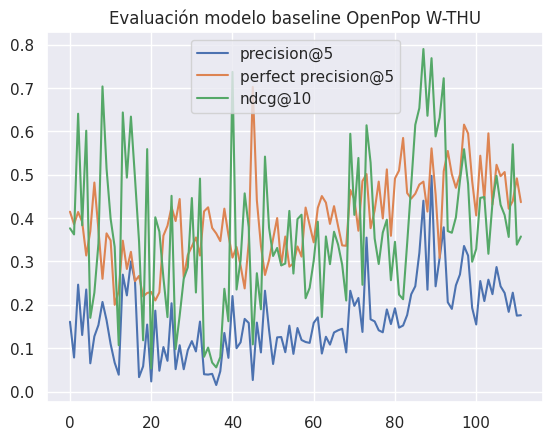

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
# Esta es la celda que no me cuadra con recsys24_daos

mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.221133,0.317018,0.236252,0.350762,0.195871,0.415802,0.310008,0.626145,0.168342,0.477611,0.344748,0.819846,0.478408,0.281155,0.989542
std,0.036484,0.053729,0.065758,0.089886,0.032825,0.077912,0.070914,0.175682,0.026979,0.070695,0.064118,0.149587,0.054643,0.053639,0.013532
min,0.175100,0.217796,0.126806,0.202459,0.143919,0.317611,0.212009,0.343667,0.136036,0.373616,0.256185,0.501146,0.421622,0.223364,0.957778
25%,0.189996,0.284524,0.185853,0.323228,0.166690,0.356735,0.250228,0.550864,0.149797,0.429708,0.291406,0.760931,0.437278,0.252214,0.987893
50%,0.225931,0.308412,0.241310,0.356970,0.201360,0.418554,0.301887,0.593693,0.155701,0.466404,0.340317,0.797410,0.467366,0.271178,0.996039
75%,0.239061,0.366925,0.290836,0.418823,0.221583,0.445135,0.368401,0.706467,0.189522,0.536397,0.405706,0.933676,0.503698,0.290716,0.997944
max,0.287129,0.384974,0.330503,0.454473,0.240594,0.569957,0.417010,1.000000,0.220118,0.573062,0.429046,1.000000,0.595266,0.411834,1.000000


,t,model,variable,value
0,2021-05-26 23:49:47,openpop,precision@5,0.160976
1,2021-06-02 23:53:44,openpop,precision@5,0.078571
2,2021-06-09 22:27:35,openpop,precision@5,0.246512
3,2021-06-16 22:05:04,openpop,precision@5,0.130435
4,2021-06-23 22:35:57,openpop,precision@5,0.235294
...,...,...,...,...
443,2023-06-14 22:25:09,perfect,recall@5,0.950594
444,2023-06-21 23:50:36,perfect,recall@5,0.967603
445,2023-06-28 21:57:25,perfect,recall@5,0.994215
446,2023-07-05 23:49:06,perfect,recall@5,0.911162


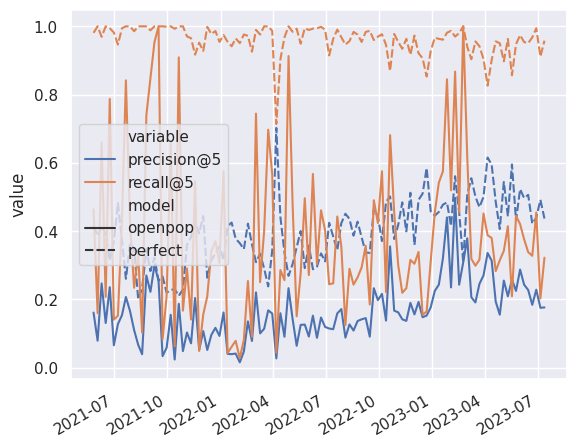

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-05-26 23:49:47,0.160976,0.319390,0.222134,0.463665,0.119512,0.376378,0.248321,0.611007,0.107317,0.426353,0.271145,0.759725,openpop
1,2021-06-02 23:53:44,0.078571,0.121039,0.078408,0.159524,0.155357,0.362251,0.195161,0.797619,0.128571,0.425122,0.224289,1.000000,openpop
2,2021-06-09 22:27:35,0.246512,0.583876,0.487360,0.659948,0.174419,0.640491,0.530256,0.820478,0.156589,0.708650,0.575414,1.000000,openpop
3,2021-06-16 22:05:04,0.130435,0.149678,0.117271,0.207246,0.173913,0.383248,0.228075,0.869565,0.130435,0.424409,0.247838,1.000000,openpop
4,2021-06-23 22:35:57,0.235294,0.529251,0.415581,0.787162,0.154902,0.601345,0.464182,0.975490,0.107190,0.609911,0.469147,1.000000,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2023-06-14 22:25:09,0.506061,1.000000,0.950594,0.950594,0.292424,1.000000,0.996786,0.996786,0.197475,1.000000,1.000000,1.000000,perfect
108,2023-06-21 23:50:36,0.421622,1.000000,0.967603,0.967603,0.236486,1.000000,0.995293,0.995293,0.161712,1.000000,0.999578,0.999578,perfect
109,2023-06-28 21:57:25,0.439252,1.000000,0.994215,0.994215,0.223364,1.000000,1.000000,1.000000,0.148910,1.000000,1.000000,1.000000,perfect
110,2023-07-05 23:49:06,0.491566,1.000000,0.911162,0.911162,0.314859,1.000000,0.974473,0.974473,0.229987,1.000000,0.993410,0.993410,perfect


Cannot show ipywidgets in text

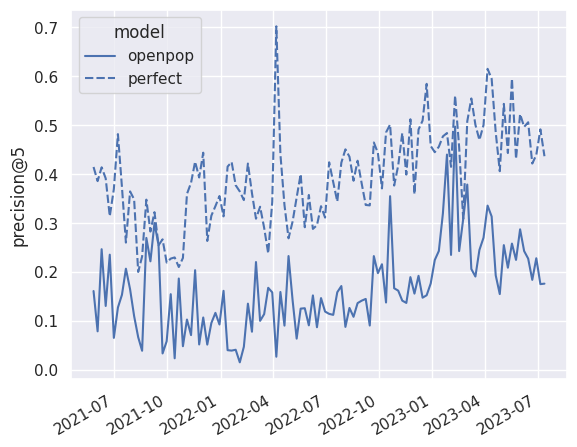

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

ax = _plot_metric('precision@5')
nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-05-26 23:49:47,0.160976,0.319390,0.222134,0.463665,0.119512,0.376378,0.248321,0.611007,0.107317,0.426353,0.271145,0.759725,openpop
1,2021-06-02 23:53:44,0.078571,0.121039,0.078408,0.159524,0.155357,0.362251,0.195161,0.797619,0.128571,0.425122,0.224289,1.000000,openpop
2,2021-06-09 22:27:35,0.246512,0.583876,0.487360,0.659948,0.174419,0.640491,0.530256,0.820478,0.156589,0.708650,0.575414,1.000000,openpop
3,2021-06-16 22:05:04,0.130435,0.149678,0.117271,0.207246,0.173913,0.383248,0.228075,0.869565,0.130435,0.424409,0.247838,1.000000,openpop
4,2021-06-23 22:35:57,0.235294,0.529251,0.415581,0.787162,0.154902,0.601345,0.464182,0.975490,0.107190,0.609911,0.469147,1.000000,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2023-06-14 22:25:09,0.506061,1.000000,0.950594,0.950594,0.292424,1.000000,0.996786,0.996786,0.197475,1.000000,1.000000,1.000000,perfect
108,2023-06-21 23:50:36,0.421622,1.000000,0.967603,0.967603,0.236486,1.000000,0.995293,0.995293,0.161712,1.000000,0.999578,0.999578,perfect
109,2023-06-28 21:57:25,0.439252,1.000000,0.994215,0.994215,0.223364,1.000000,1.000000,1.000000,0.148910,1.000000,1.000000,1.000000,perfect
110,2023-07-05 23:49:06,0.491566,1.000000,0.911162,0.911162,0.314859,1.000000,0.974473,0.974473,0.229987,1.000000,0.993410,0.993410,perfect


Cannot show ipywidgets in text

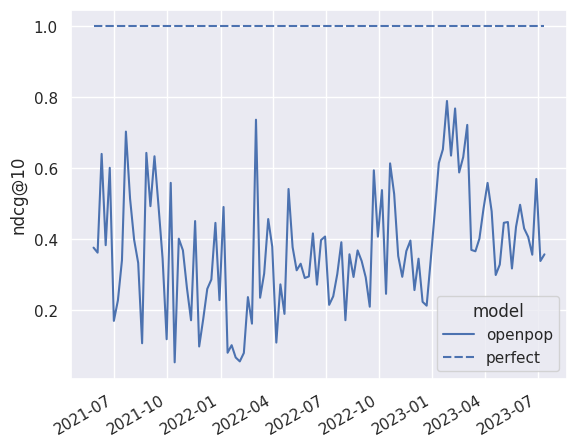

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.340741,1.0,0.989418,0.989418,0.177778,1.0,1.000000,1.000000,0.118519,1.0,1.000000,1.000000
1,0.214876,1.0,0.997639,0.997639,0.109091,1.0,1.000000,1.000000,0.072727,1.0,1.000000,1.000000
2,0.365957,1.0,0.972053,0.972053,0.206383,1.0,0.996454,0.996454,0.140426,1.0,1.000000,1.000000
3,0.372152,1.0,0.985935,0.985935,0.198734,1.0,1.000000,1.000000,0.132489,1.0,1.000000,1.000000
4,0.359223,1.0,0.946956,0.946956,0.218447,1.0,0.973738,0.973738,0.162460,1.0,0.986203,0.986203
5,0.376699,1.0,0.971529,0.971529,0.212621,1.0,1.000000,1.000000,0.141748,1.0,1.000000,1.000000
6,0.493182,1.0,0.954705,0.954705,0.285227,1.0,0.998967,0.998967,0.190909,1.0,1.000000,1.000000
7,0.497674,1.0,0.923537,0.923537,0.308721,1.0,0.986194,0.986194,0.217054,1.0,0.997984,0.997984
8,0.268333,1.0,1.000000,1.000000,0.134167,1.0,1.000000,1.000000,0.089444,1.0,1.000000,1.000000
9,0.472000,1.0,0.961557,0.961557,0.266400,1.0,0.995273,0.995273,0.181867,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000
mean,0.396267,1.0,0.961597,0.961597,0.228617,1.0,0.991958,0.991958,0.158637,1.0,0.998070,0.998070
std,0.097051,0.0,0.042427,0.042427,0.079498,0.0,0.011867,0.011867,0.060024,0.0,0.004052,0.004052
min,0.200000,1.0,0.713877,0.713877,0.100000,1.0,0.945214,0.945214,0.066667,1.0,0.974781,0.974781
25%,0.334530,1.0,0.950065,0.950065,0.177342,1.0,0.987986,0.987986,0.119579,1.0,0.998271,0.998271
50%,0.392204,1.0,0.970202,0.970202,0.222658,1.0,0.997621,0.997621,0.153710,1.0,1.000000,1.000000
75%,0.456445,1.0,0.991000,0.991000,0.276503,1.0,1.000000,1.000000,0.190745,1.0,1.000000,1.000000
max,0.702222,1.0,1.000000,1.000000,0.608889,1.0,1.000000,1.000000,0.446667,1.0,1.000000,1.000000


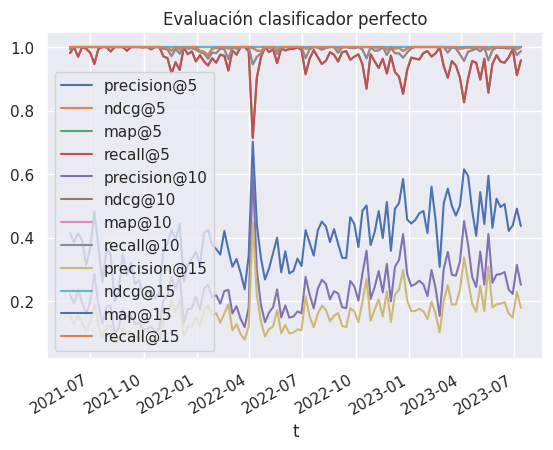

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        # 'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        # 'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        'test vpv': ts['itemID'].nunique() / len(open_proposals),
        'test vpp': len(ts) / len(open_proposals) if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 112 folds
From 2021-05-24 15:29:29 to 2023-07-20 15:42:01


,train,test,open,test users,test vpv,test vpp
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,42057.875000,316.651786,19.901786,120.205357,0.870446,19.129067
std,35298.986929,258.500343,10.895044,71.020634,0.144125,19.616697
min,419.000000,4.000000,3.000000,4.000000,0.263158,0.800000
25%,12528.750000,132.500000,12.750000,67.000000,0.813034,5.608333
50%,32315.500000,238.000000,19.000000,109.500000,0.905765,13.197917
75%,64290.750000,425.250000,24.000000,168.250000,1.000000,24.515625
max,115984.000000,1338.000000,73.000000,356.000000,1.000000,126.666667


In [36]:
fold_len.tail(10)

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
102,2023-05-11,106129,354,18,139,1.000000,19.666667,2023-05-11 00:24:03,2023-05-22 10:56:18
103,2023-05-18,107387,811,25,169,0.920000,32.440000,2023-05-18 01:09:20,2023-05-31 11:26:15
104,2023-05-25,108802,332,19,122,0.947368,17.473684,2023-05-25 00:20:18,2023-06-07 14:55:51
105,2023-06-01,109556,289,13,101,0.923077,22.230769,2023-06-01 00:00:02,2023-06-13 23:22:38
106,2023-06-08,110250,341,13,118,1.000000,26.230769,2023-06-08 00:09:03,2023-06-21 15:24:13
107,2023-06-15,111195,391,16,132,1.000000,24.437500,2023-06-15 00:22:05,2023-06-27 16:13:02
108,2023-06-22,112105,360,17,148,1.000000,21.176471,2023-06-22 00:06:41,2023-07-04 11:56:34
109,2023-06-29,112925,239,10,107,0.800000,23.900000,2023-06-29 00:01:24,2023-07-11 16:39:17
110,2023-07-06,114417,890,21,249,1.000000,42.380952,2023-07-06 00:04:34,2023-07-18 15:12:05
111,2023-07-13,115984,384,23,142,1.000000,16.695652,2023-07-13 01:09:16,2023-07-20 15:42:01


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 99 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
76,2022-11-10,51560,467,26,150,0.807692,17.961538,2022-11-10 00:02:51,2022-11-22 23:33:04,True,True
77,2022-11-17,52403,505,15,221,0.933333,33.666667,2022-11-17 00:17:11,2022-11-30 14:03:26,True,True
78,2022-11-24,53974,687,23,189,1.000000,29.869565,2022-11-24 00:03:55,2022-12-06 04:47:53,True,True
79,2022-12-01,55361,360,18,176,1.000000,20.000000,2022-12-01 00:02:56,2022-12-14 20:46:02,True,True
80,2022-12-08,56741,780,27,228,1.000000,28.888889,2022-12-08 00:27:32,2022-12-21 14:53:05,True,True
81,2022-12-15,58135,683,23,190,1.000000,29.695652,2022-12-15 00:01:53,2022-12-27 20:47:39,True,True
82,2022-12-22,60144,1242,31,260,1.000000,40.064516,2022-12-22 00:00:48,2023-01-04 18:39:29,True,True
83,2022-12-29,63375,535,29,170,0.965517,18.448276,2022-12-29 01:05:16,2023-01-09 22:06:50,True,True
84,2023-01-05,67038,396,16,156,1.000000,24.750000,2023-01-05 00:37:53,2023-01-13 07:16:06,True,True
85,2023-01-12,69677,463,14,182,0.857143,33.071429,2023-01-12 00:24:54,2023-01-21 21:21:08,True,True


In [38]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 98 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window
76,2022-11-10,51560,467,26,150,0.807692,17.961538,2022-11-10 00:02:51,2022-11-22 23:33:04,True,True,True,True
77,2022-11-17,52403,505,15,221,0.933333,33.666667,2022-11-17 00:17:11,2022-11-30 14:03:26,True,True,True,True
78,2022-11-24,53974,687,23,189,1.000000,29.869565,2022-11-24 00:03:55,2022-12-06 04:47:53,True,True,True,True
79,2022-12-01,55361,360,18,176,1.000000,20.000000,2022-12-01 00:02:56,2022-12-14 20:46:02,True,True,True,True
80,2022-12-08,56741,780,27,228,1.000000,28.888889,2022-12-08 00:27:32,2022-12-21 14:53:05,True,True,True,True
81,2022-12-15,58135,683,23,190,1.000000,29.695652,2022-12-15 00:01:53,2022-12-27 20:47:39,True,True,True,True
82,2022-12-22,60144,1242,31,260,1.000000,40.064516,2022-12-22 00:00:48,2023-01-04 18:39:29,True,True,True,True
83,2022-12-29,63375,535,29,170,0.965517,18.448276,2022-12-29 01:05:16,2023-01-09 22:06:50,True,True,True,True
84,2023-01-05,67038,396,16,156,1.000000,24.750000,2023-01-05 00:37:53,2023-01-13 07:16:06,True,True,True,True
85,2023-01-12,69677,463,14,182,0.857143,33.071429,2023-01-12 00:24:54,2023-01-21 21:21:08,True,True,True,True


            train  test  i
t                         
2021-05-27    419    94  0
2021-06-03    937   108  1
2021-06-10   1307   101  2
2021-06-17   1555    45  3
2021-06-24   1877    82  4
2021-07-01   2200    92  5
2021-07-08   2602    63  6
2021-07-15   2902    57  7
2021-07-22   3132    39  8
2021-07-29   3276    31  9


Cannot show ipywidgets in text

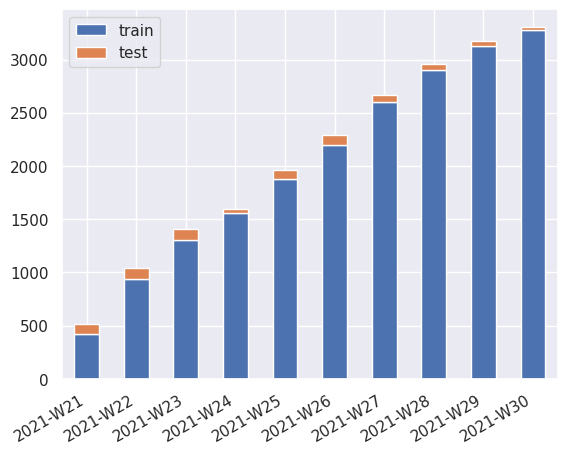

In [39]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

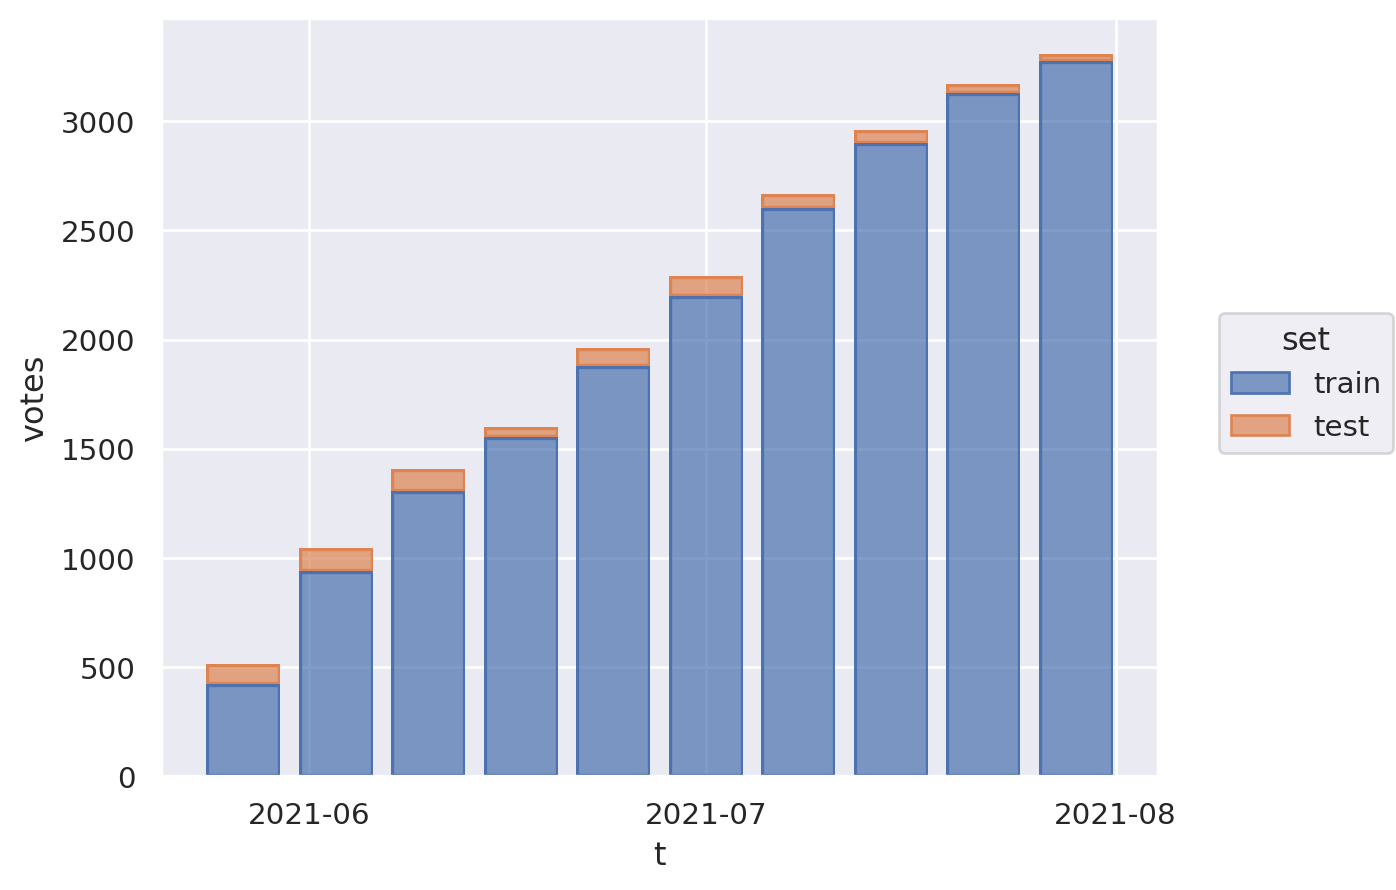

In [40]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())